Todo : 
- implement UCB1
- implement Exp3-IX
- check if there are other algorithms
- find good experiments to compare algorithms

# Exp-3 algorithm
cf https://jeremykun.com/2013/11/08/adversarial-bandits-and-the-exp3-algorithm/

In [324]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [325]:
# need to define class arm (cf TD2)
class Arm():
    """ 
    Defines an arm with arbitrary finite sequence of reward
    """
    def __init__(self, rewards_sequence):
        self.rewards = rewards_sequence
        
    def sample(self, t):
        return self.rewards[t]

In [326]:
def exp3(MAB, T, gamma):
    """
    Exp3 algorithm as in Auer et al. (2001)
    MAB: list of arms from Arm class
    T: the time horizon
    gamma: random jump parameter
    """
    reward_hist = []
    K = len(MAB) # number of arms
    W = np.ones(K) # initialize weights
    
    for t in range(T):
        p = (1-gamma)*W/np.sum(W) + gamma/K # set probabilities of drawing each arm
        drawn_index = np.where(np.random.multinomial(n=1, pvals=p))[0][0] # draw arm index
        drawn_reward = MAB[drawn_index].sample(t) # corresponding reward
        estimated_reward = drawn_reward/p[drawn_index] # compute estimated reward
        W[drawn_index] *= np.exp(gamma*estimated_reward/K) # update weights
        reward_hist.append(drawn_reward) # retrain reward
    return reward_hist

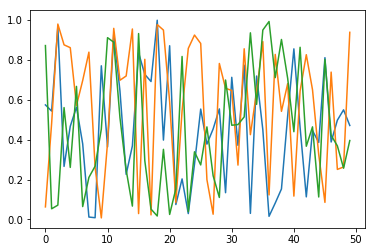

In [327]:
# 3 arms bandit, the reward of each arm is distributed as a uniform over [0, 1]
# Not a good example, too noisy -> picking arm uniformly at random should perform well
# Need to add a bit of structure...

T = 50
arm1 = Arm(np.random.uniform(0, 1, T))
arm2 = Arm(np.random.uniform(0, 1, T)) 
arm3 = Arm(np.random.uniform(0, 1, T)) 

MAB = [arm1, arm2, arm3]

plt.plot(arm1.rewards)
plt.plot(arm2.rewards)
plt.plot(arm3.rewards)

In [328]:
# we define gaussian trajectories normalized to lie in [0, 1]

def gaussian_traj(T):
    gp = np.cumsum(np.random.normal(0, 2, T))

    # normalization (to have rewards in [0, 1]) :
    gp += np.abs(min(gp))
    gp /= max(gp)
    return(gp)

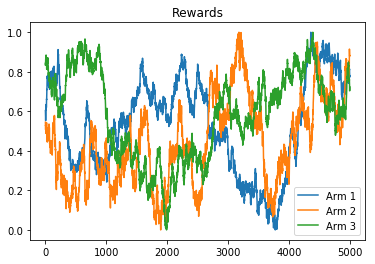

In [329]:
T = 5000

arm1 = Arm(gaussian_traj(T))
arm2 = Arm(gaussian_traj(T))
arm3 = Arm(gaussian_traj(T))

MAB = [arm1, arm2, arm3]

plt.plot(arm1.rewards)
plt.plot(arm2.rewards)
plt.plot(arm3.rewards)
plt.legend(['Arm 1', 'Arm 2', 'Arm 3'])
plt.title('Rewards')

In [330]:
arm1_cumsum = np.cumsum(arm1.rewards)
arm2_cumsum = np.cumsum(arm2.rewards)
arm3_cumsum = np.cumsum(arm3.rewards)
exp3_cumsum = np.cumsum(exp3(MAB, T, 0.1))

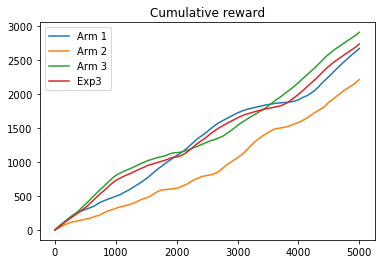

In [331]:
plt.plot(np.cumsum(arm1.rewards))
plt.plot(np.cumsum(arm2.rewards))
plt.plot(np.cumsum(arm3.rewards))
plt.plot(exp3_cumsum)
plt.legend(['Arm 1', 'Arm 2', 'Arm 3', 'Exp3',])
plt.title("Cumulative reward")

In [332]:
best_action_rew = []
for t in range(T):
    best_action_rew.append(max(arm1_cumsum[t], arm2_cumsum[t], arm3_cumsum[t]))

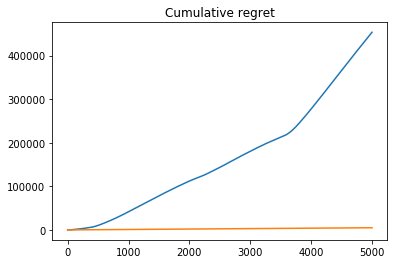

In [335]:
plt.plot(np.cumsum(best_action_rew - exp3_cumsum))
plt.title('Cumulative regret')

lin = [t for t in range(T)]
plt.plot(lin) 
# There seems to be a pb because the regret is worse than linear in T